In [ ]:
pip install shap

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import joblib
import shap
images_dir = 'C:/naira_sentry/visuals'

In [12]:
df = pd.read_csv("../data/processed/full_data.csv")
model = joblib.load('../models/isolation_forest_model.pkl')

In [13]:
features = [
    'hour', 
    'day_of_week', 
    'payment_channel_code', 
    'device_used_code', 
    'location_code', 
    'transaction_type_code', 
    'amount_log'
]
X = df[features]

In [16]:
# GENERATE PREDICTIONS 
# -1 = Anomaly, 1 = Normal
df['anomaly_score'] = model.decision_function(X) 
df['prediction'] = model.predict(X) 


<IPython.core.display.Javascript object>

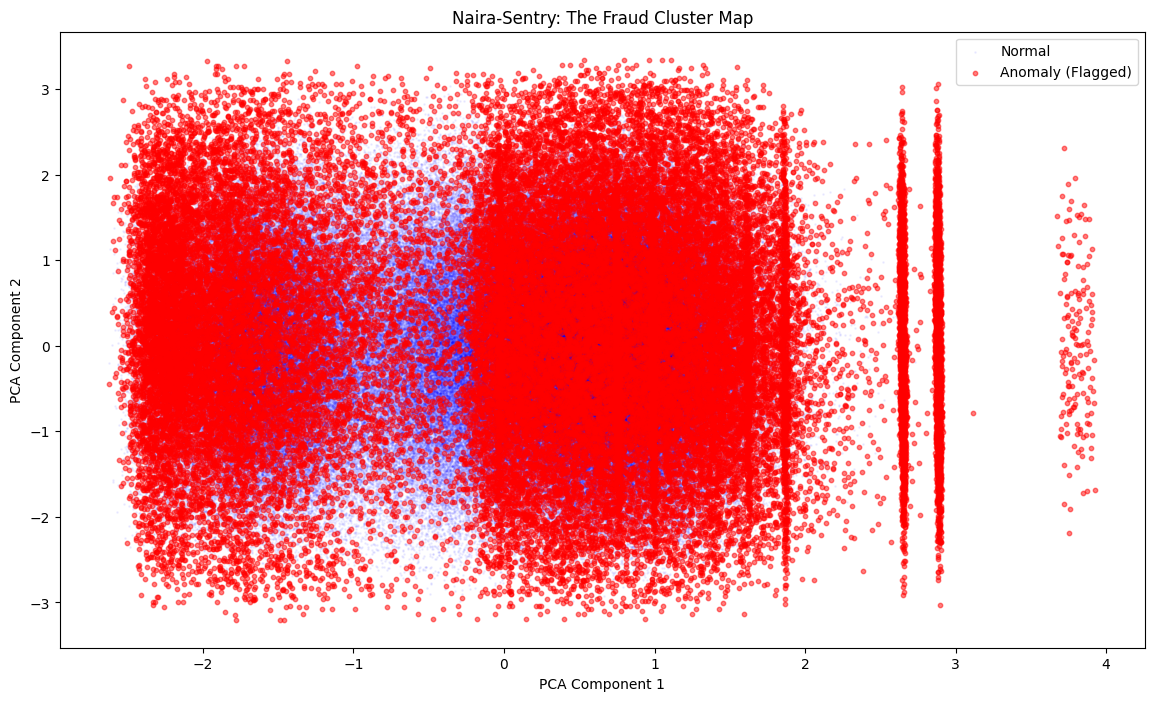

In [20]:
# PCA (Squash 7D -> 2D)
# Standardize first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

df['pca_x'] = components[:, 0]
df['pca_y'] = components[:, 1]

# PLOT THE CLUSTERS 🔴 🔵
plt.figure(figsize=(14, 8))

# Plot Normal (Blue) - Alpha is low to see density
normal = df[df['prediction'] == 1]
plt.scatter(normal['pca_x'], normal['pca_y'], c='blue', alpha=0.05, label='Normal', s=1)

# Plot Anomalies (Red)
anomalies = df[df['prediction'] == -1]
plt.scatter(anomalies['pca_x'], anomalies['pca_y'], c='red', alpha=0.5, label='Anomaly (Flagged)', s=10)

plt.title("Naira-Sentry: The Fraud Cluster Map")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.savefig(os.path.join(images_dir, "fraud_cluster.png"))
plt.show()

In [22]:
profile = df.groupby('prediction')[features].mean()
profile['count'] = df.groupby('prediction')['amount_log'].count()

print("Average Behavior: Normal (1) vs Anomaly (-1)")
print(profile.T)

Average Behavior: Normal (1) vs Anomaly (-1)
prediction                      -1              1
hour                      11.10524      12.413960
day_of_week                3.03470       2.965242
payment_channel_code       1.47512       1.503102
device_used_code           1.39182       1.511616
location_code              4.92962       4.447342
transaction_type_code      1.59258       1.490742
amount_log                11.34749      11.953428
count                  50000.00000  450000.000000


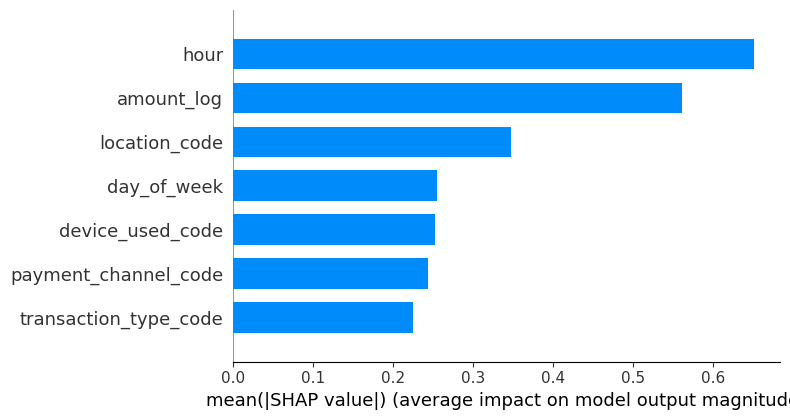

In [26]:
explainer = shap.TreeExplainer(model)

# Sample 100 anomalies to keep it fast
anomaly_sample = X[df['prediction'] == -1].sample(100, random_state=42)
shap_values = explainer.shap_values(anomaly_sample)

#  Summary Plot
shap.summary_plot(shap_values, anomaly_sample, plot_type="bar")